#### Machine Learning in Python - Project 1

Authors: Constantinos Mavrommatis and Matt Carre

## Setup

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Scikit-learn Preprocessing & Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, PolynomialFeatures
# Scikit-learn Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
# Set plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [2]:
# Function to retrieve model coefficients
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array."""
    if isinstance(m, sklearn.pipeline.Pipeline):
        m = m.steps[-1][1]
    return np.concatenate([[m.intercept_], m.coef_]) if m.intercept_ is not None else m.coef_

# Function to evaluate model performance
def model_fit(m, X, y, plot=False):
    """Returns MSE, RMSE, and R^2 value of a fitted model."""
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(MSE)
    Rsqr = r2_score(y, y_hat)
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    if plot:
        res = pd.DataFrame({'y': y, 'y_hat': y_hat, 'resid': y - y_hat})
        
        plt.figure(figsize=(9, 4))
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color='grey', data=pd.DataFrame({'y': [min(y), max(y)], 'y_hat': [min(y), max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Observed vs Fitted values")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted values vs Residuals")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors='black')
        plt.suptitle(f"Model (MSE, RMSE, Rsq) = {Metrics}", fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [3]:
# Load data
d = pd.read_csv("adnidata.csv")

# Introduction

In this report, we propose a new model for predicting Alzheimer’s disease outcomes over a two-year period. Our approach uses a Lasso regression with polynomial features, which captures interaction terms and automatically removes those that fail to provide meaningful information about the 24-month ADAS13 cognitive test score. The dataset on which we trained and tested this model included information on sizes of varied portions in the patient's brain, a description of their ethnic makeup, race, history in eduction, marital status, original score on the ADAS13 cognitive test, score after 24 months, determining what the original level of cognitive impairment they were suffering from, and if they carry alleles for the APOE4 gene.

We evaluated our final polynomial-Lasso model on a held out test set, achieving a Mean Squared Error (MSE) of 30.97, a Root Mean Squared Error (RMSE) of 5.56, and an R² of 0.813. By comparison, our baseline linear model attained an MSE of 34.43, an RMSE of 5.87, and an R² of 0.793 on the same test data. These results indicate that our final approach is a robust and suitable choice for anticipating cognitive decline well before more severe symptoms appear. The stronger predictive performance of the polynomial-Lasso model arises from its ability to handle complex interactions among features (e.g., interactions between brain structures, baseline cognition, and genetic factors) while penalizing and eliminating redundant terms.

For a professional body focused on aging and dementia such as the Alzheimer’s Association our model can serve as a basis for early intervention strategies, by identifying factors linked to a higher risk of cognitive decline, clinicians and researchers could deploy more targeted monitoring and interventions aimed at slowing the progression of Alzheimer’s. Our subsequent sections detail the data processing methods, the rationale behind the Lasso model with polynomial expansions, the final model’s performance, and potential applications of these findings for public health and patient care.

# Exploratory Data Analysis and Feature Engineering

In this section, we will be discussing the thought process that guided our selection of which features to include in the final model, that ultimately predicts the impact on the ADAS score after two years of the initial diagnosis. We also explore the data for important findings or ways to improve model selection.

First, Table 1 summarizes the data types and the null counts in each column. Columns with int64 and float64 are continuous features, whereas object types are categorical features, this distinction is crucial for the preprocessing of the model pipeline, because different features require different imputation or encoding methods in our pipeline. Moreover, the table reveals that certain columns contain missing data and need an imputation strategy to fill the missing values. That is because if we dropped rows with missing data, we would lose 17% of our data, which is undesirable with further complications of scikit-learn not being able to handle missing values well.

In [4]:
summary = pd.DataFrame({
    'Data Type': d.dtypes,
    'Non-Null Count': d.count(),
    'Null Count': d.isna().sum(),
    'Null Count Percentage': round((d.isna().sum() / d.count()) * 100)
})
print("Table 1: A summary of the dataset, showing data types, non-null counts, and missing values.")
display(summary)

Table 1: A summary of the dataset, showing data types, non-null counts, and missing values.


,Data Type,Non-Null Count,Null Count,Null Count Percentage
Unnamed: 0,int64,1038,0,0.0
RID,int64,1038,0,0.0
ADAS13.bl,float64,1038,0,0.0
ADAS13.m24,float64,1038,0,0.0
AGE,float64,1038,0,0.0
DX.bl,object,1038,0,0.0
PTGENDER,object,1038,0,0.0
PTEDUCAT,int64,1038,0,0.0
PTETHCAT,object,1038,0,0.0
PTRACCAT,object,1038,0,0.0


Furthermore, our dataset included multiple columns that were redundant, for example two ID columns (Unnamed: 0, RID) and several pieces of information that did not seem to affect Alzheimer’s prognosis significantly. One such piece of information was PTEDUCAT (the patient’s years in education) that based on the established research has minimal impact, our model did not perform better by including it, but that does not mean it is unimportant, rather it may need to be combined with other metrics that are not in our dataset to show a meaningful difference. Although some studies claim an association between education and reduced effects of Alzheimer’s (Sharp and Gatz, 2012), statistical evidence often remains limited. Additionally, PTRACCAT was also removed since the patient’s ethnicity did not improve our model, even though it showed some effect, possibly because the variance contributed by ethnicity was already explained by other features.

In [5]:
# Extract features and target variable
X = d.drop(columns=["ADAS13.m24", "Unnamed: 0", "RID","PTEDUCAT", "PTRACCAT"])
y = d["ADAS13.m24"].copy()

Before building our model, the data was split into training and testing sets using train_test_split with a 70/30 ratio, seeded by a random state. Splitting ensures that the model learns based on training data only, avoiding any data leakage:

In [6]:
# Split data into training and testing sets
rng = np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

In [7]:
# Combine X_train and y_train into a single DataFrame
train_data = X_train.copy()
train_data["ADAS13.m24"] = y_train  # Adding y_train as a column

In preparation for exploring the data, we separate continuous and categorical features:

In [8]:
#Feature Extraction of Numerical Features
features = list(train_data.select_dtypes(exclude=['object']).columns)

The following histograms (Figure 1) display approximate counts and skew for each categorical feature, including APOE4, which despite being numeric behaves more like a categorical predictor here. These plots also illustrate the presence of minority groups in the categorical data, which influences whether and how we combine them using max_categories in our one-hot encoding approach later. Most likely, we will choose to have two categories to produce a more balanced distribution of counts:

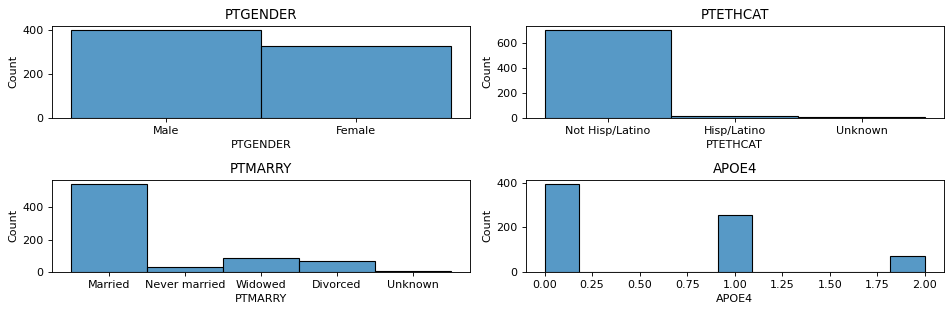

In [9]:
# list of categorical features
cat_features = ["PTGENDER", "PTETHCAT", "PTMARRY", "APOE4"]

# Creation of subplots
fig, axes = plt.subplots(figsize=(12, 4), nrows=2, ncols=2)
axes = axes.flatten()

# Plot a countplot for each categorical feature
for i, feature in enumerate(cat_features):
    sns.histplot(x=X_train[feature], ax=axes[i])
    axes[i].set_title(feature)

# Turn off any extra subplots if there are fewer features than axes
for j in range(len(cat_features), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

*Figure 1: Count distributions for each categorical feature in X_train.*



To investigate feature relationships, we next examine how each predictor correlates with ADAS13.m24, this also helps identify features that could potentially be grouped together for feature reduction. As shown, many of the brain scan variables are highly correlated with each other, although we chose not to group them because each represents a distinct anatomical measure potentially linked to Alzheimer’s progression, ADAS13.m24. We also see that APOE4 is positively correlated with ADAS13.m24, meaning that higher APOE4 scores tend to increase ADAS13.m24. Meanwhile, most brain scan measurements show negative correlations with ADAS13.m24 (an increase in volume is linked to a lower ADAS13.m24), except for Ventricles which is the opposite. However, the strongest correlation is from ADAS13.bl (the baseline ADAS score), indicating it is likely the biggest driver of the final ADAS13.m24 score.

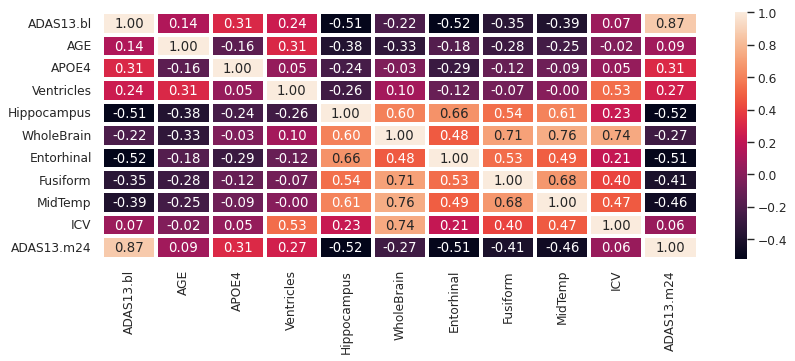

In [10]:
# Correlation Heatmap
sns.set(rc={'figure.figsize': (12, 4)})
sns.heatmap(data=train_data.corr(numeric_only=True), annot=True, fmt=".2f", linewidths=2)
plt.show()

*Figure 2: Correlation heatmap of continuous variables in train_data.*

We confirm these relationships more rigorously using Pearson’s correlation test (Table 2), ensuring they are unlikely to be due to random chance:

In [11]:
print("Table 2: Feature Correlation with ADAS13.m24")

# Correlation Analysis
train_data_na_rm = train_data.dropna()

# Initialize an empty DataFrame to store correlations
all_corr = pd.DataFrame()

for feature in train_data.columns:
    if train_data_na_rm[feature].dtype != 'object' and feature != "ADAS13.m24":
        corr = pd.DataFrame(stats.pearsonr(train_data_na_rm[feature], train_data_na_rm["ADAS13.m24"]),
                            index=["cor", "p-values"],
                            columns=[feature])
        # Checks if the feature has already been added
        if feature not in all_corr.columns:
            all_corr = pd.concat([all_corr, corr], axis=1)

display(all_corr.round(3).sort_values(by="cor", axis=1))

Table 2: Feature Correlation with ADAS13.m24


,Hippocampus,Entorhinal,MidTemp,Fusiform,WholeBrain,AGE,ICV,Ventricles,APOE4,ADAS13.bl
cor,-0.51,-0.505,-0.455,-0.406,-0.266,0.063,0.063,0.271,0.325,0.88
p-values,0.00,0.000,0.000,0.000,0.000,0.118,0.116,0.000,0.000,0.00


Table 2 reveals that most correlations are statistically significant (p<0.05), which means we reject the null hypothesis that the correlations are not statistically different from zero. On the other hand, Agea and ICV are not statistically significant (p>0.05), suggesting their apparent correlations might be due to chance.

Next, we created Q-Q plots (Figure 3) to test normality across numerical features. Most appear approximately linear, so no immediate transformations (like log or square-root) were applied before developing our initial models.

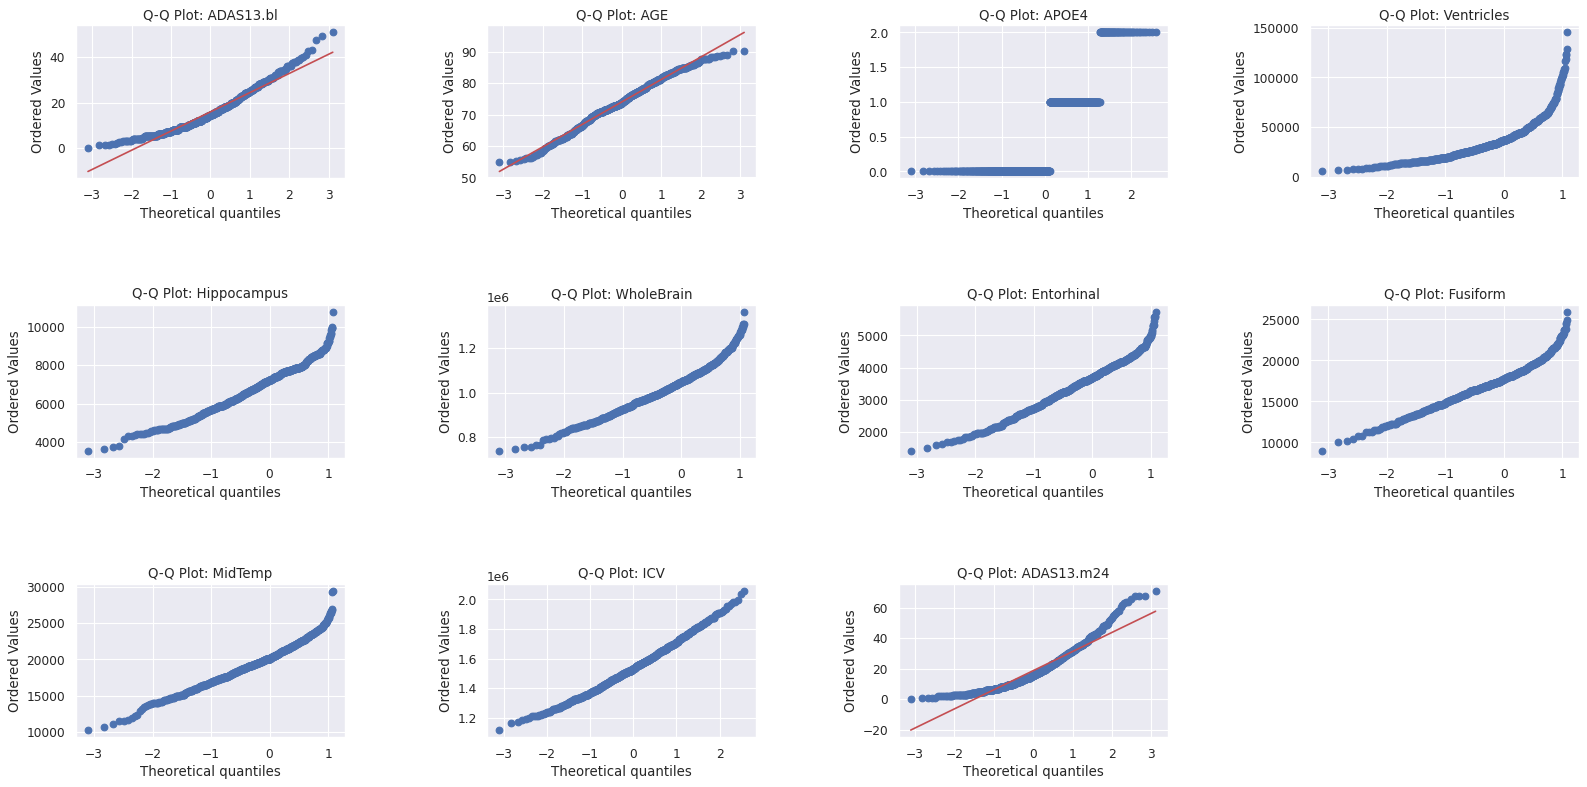

In [12]:
# Q-Q Plots for Normality Check
fig, axes = plt.subplots(3,4, figsize=(20,10))
axes = axes.flatten()
for i, feature in enumerate(features):
    stats.probplot(train_data[feature], dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q Plot: {feature}")

for j in range(len(features), len(axes)):
    axes[j].axis("off")

plt.tight_layout(h_pad=5, w_pad=5)
plt.show()

*Figure 3: Q-Q plots indicating approximate normality for most continuous variables.*

Finally, we present boxplots (Figure 4) to visualize potential outliers. While outliers are indeed present, we chose to keep them, believing they might represent meaningful cases or minority subgroups within the dataset. Removing them might erase valuable information.

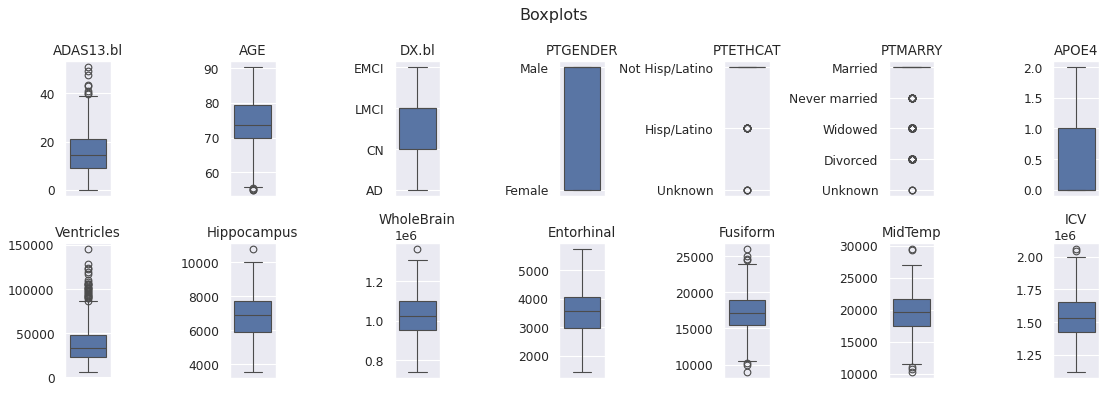

In [13]:
# Boxplots for Feature Distributions
fig, axes = plt.subplots(figsize=(14,5), ncols=X.shape[-1]//2, nrows=2, sharex=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.boxplot(y=X_train.iloc[:, i], ax=ax)
    ax.set_title(X_train.columns[i])
    ax.set_ylabel("")
plt.suptitle("Boxplots")
plt.tight_layout()
plt.show()

*Figure 4: Boxplots revealing outliers in multiple variables.*

Based on all the above data analysis, the basis of the feature engineering for the model pipelines can be broken down into three main parts: numerical, categorical, and ordinal feature preprocessing. First, the numerical preprocessing takes the columns with numeric values and imputes any empty cells with the median value of that column. This strategy is achieved using the SimpleImputer library from scikit-learn, chosen so that we avoid removing rows with missing data, given that scikit-learn does not handle missing values gracefully in subsequent modeling steps.

On the other hand, the categorical features are processed using a OneHotEncoder, it operates by taking each unique categorical value and creating an individual binary (0/1) feature column. We have further adjusted this encoder to allow up to two new categories/features to be created, with this decision being based on the histogram of counts for the categorical features, which often showed one dominant category and several smaller ones, helping us reduce the total number of categories while maintaining higher counts in each.

Next, we apply an ordinal encoder to data where there is a logical order from lowest to highest. Since our baseline diagnosis feature (DX.bl) follows a natural progression, it is straightforward to define the order and see how each category influences our target (ADAS13.m24).

All features in the end are standardized using the scikit-learn StandardScaler, which subtracts the mean and divides by the standard deviation for each feature, transforming them so that they have a mean of 0 and a standard deviation of 1. This process is crucial because it ensures that all features contribute equally to the model by preventing those with larger scales from dominating the learning process and allows for a fair comparison of feature importance. Standarizing the data helps regularization techniques like ridge or lasso regression that are sensitive to the scale of input features.

In [14]:
# Define preprocessing pipelines
num_pre = Pipeline([
    ("num_impute", SimpleImputer(strategy="median"))
])

cat_pre = Pipeline([
    ("num_impute", SimpleImputer(strategy="most_frequent")),
    ("cat_encode", OneHotEncoder(max_categories=2, handle_unknown ="ignore"))
])

ord_pre = Pipeline([
    ("ord_encode", OrdinalEncoder(categories=[['CN','EMCI','LMCI','AD']]))
])

Standard_Scaler = StandardScaler()

# Model Fitting and Tuning

As we stated in the intoduction part of this report the goal of our model is to predict the cognitive decline of an individual in a 24 month follow-up visit. This is based on the information collected at the baseline visit and based on our research the data have been pre processed and different aproached have been considered to maximaze the predictive capabilities of our model. This is important since an accurate and interpretable model will aid in underatnding the major contributers of cognitive decline and will give potiential high risk individuals the ability to diselerate as much as possible the disease by taking early measures.

Thus, we initially explored a standard linear regression model (with and without polynomial terms), Ridge Regression, Elastic and Lasso. After preliminary comparisons, we selected Lasso due to its better performance in validation and its natural feature selection capabilities. Below, we briefly describe the baseline model that is going to be used as a point of reference for our more sophisticated lasso model.

The baseline model is a simple linear regression model with the basic feature engineering steps applied to all the model pipelines we tried. As mentioned before, there are three pre-processing steps that have been applied to give the model the best chance to perform well. We chose a linear model to provide a point of reference, a model that lacks the extra polynomial features or any regularization penalties.

In [15]:
numcols = [0,1,7,8,9,10,11,12,13]
ordcols = [2]
catcols = [3,4,5,6]

# Define Linear Regression Model
reg_pipe_1 = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, numcols),
        ("cat_pre", cat_pre, catcols),
        ("ord_pre", ord_pre, ordcols)
    ])),
    ("scaler", Standard_Scaler),
    ("model", LinearRegression())
])

In [16]:
param_grid = {}

# Define a cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=1234)

# Wrap the pipeline in GridSearchCV
gs_pipe = GridSearchCV(
    estimator=reg_pipe_1,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=cv_strategy
)

# Fit on training data
base_model=gs_pipe.fit(X_train, y_train)
best_base_model = base_model.best_estimator_  # This is your pipelin

print('CV MSE for base model',round(-gs_pipe.best_score_,4))

CV MSE for base model 36.9627


The baseline model was cross-validated, producing a CV MSE score that we used as an initial benchmark for comparison with other models, that allowed us to see which models show the most promise early on. I also want to mention that the baseline model does not use polynomial feature engineering because, we found that adding polynomial features without any form of regularization significantly increased overfitting, a consequence of the high-degree of polynomial terms.

In [17]:
MSE_train_base, RMSE_train_base, Rsqr_train_base = model_fit(best_base_model, X_train, y_train, plot=False)
MSE_test_base, RMSE_test_base, Rsqr_test_base = model_fit(best_base_model, X_test, y_test, plot=False)

print(f"Train performance Baseline Model - MSE:{MSE_train_base}, RMSE:{RMSE_train_base}, Rsqr:{Rsqr_train_base}")
print(f"Test performance Baseline Model - MSE:{MSE_test_base}, RMSE:{RMSE_test_base}, Rsqr:{Rsqr_test_base}")

Train performance Baseline Model - MSE:35.00902044252, RMSE:5.916842100522879, Rsqr:0.796883873028958
Test performance Baseline Model - MSE:34.08494157604819, RMSE:5.838231031403963, Rsqr:0.7946528267255843


The above metrics show the baseline model’s real-world performance,with the similarity between training and test performance suggesting that the model is generalizing reasonably well and is not heavily overfitting. The RMSE of roughly 5.8 points means that, on average, the model’s predictions are off by about 6 points. Meanwhile, an R² of around 0.79 indicates that the model captures a large portion of the variability in the scores, which is a strong result for a simple linear regression.

In [18]:
# Define Ridge Regression Model
pf = PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)

alphas = np.linspace(1, 50, num=100)  

reg_pipe_2 = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, numcols),
        ("cat_pre", cat_pre, catcols),
        ("ord_pre", ord_pre, ordcols)
    ])),
    ("poly", pf),
    ("scaler", Standard_Scaler),
    ("model", Ridge())
])

# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)

#Grid search
gs_ridge = GridSearchCV(
    reg_pipe_2,
    param_grid={'model__alpha': alphas},  # matches the step name "lasso"
    cv=cv,
    scoring="neg_mean_squared_error"
)

# Train and evaluate Ridge Regression Model
ridge_model = gs_ridge.fit(X_train, y_train)
best_ridge_model = ridge_model.best_estimator_

MSE_train, RMSE_train, Rsqr_train = model_fit(best_ridge_model, X_train, y_train, plot=False)
MSE_test, RMSE_test, Rsqr_test = model_fit(best_ridge_model, X_test, y_test, plot=False)

print("Training performance:", (MSE_train, RMSE_train, Rsqr_train))
print("Test performance:", (MSE_test, RMSE_test, Rsqr_test))

Training performance: (31.30247855911427, 5.594861799822608, 0.8183885715979858)
Test performance: (30.998980792451803, 5.567672834537945, 0.8132444186264641)


In [19]:
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

alphas = np.linspace(0.001, 1.0, 10)
l1r = [0.01, .1, .5, .7, .9, .95, 1]

enet_cv = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, numcols),
        ("cat_pre", cat_pre, catcols),
        ("ord_pre", ord_pre, ordcols)
    ])),
    ("poly", pf),
    ("scaler", StandardScaler()),
    ("model", ElasticNetCV(max_iter=10000, tol=1e-4))
])

# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)

#Grid search
gs_elastic = GridSearchCV(
    enet_cv,
    param_grid={'model__alphas': [alphas], 'model__l1_ratio': l1r},  # matches the step name "lasso"
    cv=cv,
    scoring="neg_mean_squared_error"
)
# Fit model
Elastic_model = gs_elastic.fit(X_train, y_train)
best_elastic_model= Elastic_model.best_estimator_

MSE_train, RMSE_train, Rsqr_train = model_fit(best_elastic_model, X_train, y_train, plot=False)
MSE_test, RMSE_test, Rsqr_test = model_fit(best_elastic_model, X_test, y_test, plot=False)

print("Training performance:", (MSE_train, RMSE_train, Rsqr_train))
print("Test performance:", (MSE_test, RMSE_test, Rsqr_test))

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.974e+03, tolerance: 7.764e+00
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.190e+03, tolerance: 7.693e+00
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.032e+03, toleran

Training performance: (33.42963585162428, 5.781836719557574, 0.8060471822859876)
Test performance: (31.83026585897079, 5.641831782229136, 0.8082362821679037)


Moving to the final model choice, it was mainly inspired by several reasons, first, after running cross-validation, Lasso outperformed the other models (Ridge, Baseline Linear Regression, and ElasticNet) in terms of CV MSE. We also suspected that Lasso would be our final choice because it handles correlated features well, something seen in Figure 2 when we noticed multicollinearity (such as brain volume measurements). Additionally, based on background research, we expected many combinations of factors to be at play, so we performed polynomial feature engineering to create multiple interactions. Lasso is perfect here because it automatically performs feature selection by shrinking coefficients to zero ($\ell_1$ penalty), leading to a more generalizable model when dealing with noisy data. Unlike Ridge regression, which shrinks coefficients but keeps all features, Lasso can completely remove less important predictors, making the model simpler and easier to interpret.

In [20]:
alphas = np.linspace(0.010, 0.500, num=100)

pf = PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)

reg_pipe_3 = Pipeline([
    ("pre_processing", ColumnTransformer([
        ("num_pre", num_pre, numcols),
        ("cat_pre", cat_pre, catcols),
        ("ord_pre", ord_pre, ordcols)
    ])),
    ("poly", pf),
    ("scaler", Standard_Scaler),
    ("model", Lasso(max_iter=10000))
])

The above code depicts the model pipeline used to construct our final Lasso polynomial model. As mentioned in the feature engineering and baseline model sections, all models have had three main preprocessing steps that use the ColumnTransformer from the scikit-learn library. This transformer applies the subsequent steps to the relevant columns in the data, whether training or test, ensuring that there is no leakage between them. It applies numerical imputation to any missing continuous values using the median of each column, as we believed this would be the best approach without skewing columns that had a substantial number of missing values. The alternative, dropping rows with missing data, would have resulted in losing valuable information. Next, for categorical features, we used one-hot encoding, which created multiple columns as previously mentioned, and the final ordinal encoder handled the diagnosis of the individual at the baseline visit (DX.bl). After these preprocessing steps, we add polynomial feature creation to capture feature interactions, allowing for a more in-depth view of how the data affects our predictor. However, we restrict this to interaction-only terms with a degree of 2 to keep complexity under control. To conclude, standardization is applied to both the original features and the newly created polynomial features so we can accurately interpret each feature’s impact on predictions, given that their measurement scales differ. These features are then fed into our Lasso model to predict the ADAS score after two years.

To optimize our Lasso model, we performed a grid search over a range of α values, with 5-fold cross-validation systematically evaluating each value. Our goal was to minimize mean squared error (MSE) on the test folds, striking a balance between balance model complexity (underfitting and overfitting) while maintaining interpretability.

In [21]:
# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)

#Grid search
gs_lasso = GridSearchCV(
    reg_pipe_3,
    param_grid={'model__alpha': alphas},  # matches the step name "lasso"
    cv=cv,
    scoring="neg_mean_squared_error"
)

lasso_model = gs_lasso.fit(X_train, y_train)
best_lasso_model = lasso_model.best_estimator_

print( f"Alpha tha achived the best cross-validated MSE {gs_lasso.best_params_}")

Alpha tha achived the best cross-validated MSE {'model__alpha': 0.06939393939393938}


We created a grid of possible α values using np.linspace(0.010, 0.500, num=100). We then passed this grid to GridSearchCV, specifying the parameter name "model__alpha" (because our Lasso model is the "model" step in the pipeline). GridSearchCV iterated over each α and trained a new Lasso model, ultimately identifying the α that achieved the best cross-validated MSE, which was selected as the optimal regularization strength (Alpha = 0.069). The argument cv=cv (with KFold(5, shuffle=True)) tells GridSearchCV how to split the data for training/validation. This is where the actual validation takes place.

The strategy used was 5-fold cross-validation (KFold(n_splits=5, shuffle=True, random_state=1234)) to ensure each α was rigorously tested. In each fold, the data is split into training and validation subsets, the model then is fit on four folds (training) and evaluated on the remaining fold (validation). This process is repeated five times, each time with a different fold held out for validation. By averaging performance across these 5 folds, we get a robust estimate of how well the model generalizes. The param_grid={'model__alpha': alphas} inside GridSearchCV instructs scikit-learn to try each alpha and pick the best based on cross-validation performance.

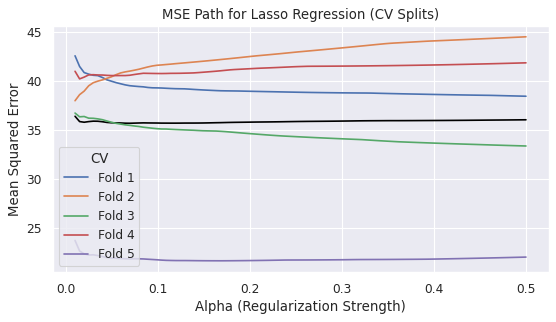

In [22]:
# DataFrame from grid search results with extracted test scores for each split
cv_mse = pd.DataFrame(data=gs_lasso.cv_results_).filter(
    regex='(split[0-9]+)_test_score'
)

# Converting negative MSEs to positive values
cv_mse.update(-1 * cv_mse.filter(regex='_test_score'))

# Rename columns
fold_names = ['Fold ' + str(i + 1) for i in range(5)]
cv_mse.columns = fold_names

# Adding the alphas used in grid search as a column in the DataFrame
cv_mse['alpha'] = alphas

# Reshaping the DataFrame from wide to long format for plotting with seaborn
d = cv_mse.melt(
    id_vars='alpha',
    var_name='CV',
    value_name='MSE'
)

# Ploting the MSE path: overall mean and individual fold curves
plt.figure(figsize=[8, 4])
sns.lineplot(x='alpha', y='MSE', color='black', errorbar=None, data=d)  # Mean MSE curve
sns.lineplot(x='alpha', y='MSE', hue='CV', data=d)  # Individual fold curves
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.title('MSE Path for Lasso Regression (CV Splits)')
plt.show()

*Figure 6: Mean Squared Error (MSE) Solution Path*

Visualising from what we were explaining before, Figure 6 shows how MSE changes as α increases (stronger regularization). The black curve shows the overall (mean) MSE acros all folds at each step while the colored lines represent the individual folds, ilustrating variance between splits, with different folds responding slightly differently, but the overall mean (black line) typically has a clear minimum region. The best α found by GridSearchCV is where the average MSE is lowest. Thus, we conclude that GridSearchCV + 5-fold cross-validation not only provides an optimal hyperparameter (α) for our Lasso model but also offers insight into how the model’s predictive performance changes across different levels of regularization.

In [23]:
print(f"Initial performance metrics used to finalize our model selection:\n")
print(f"CV MSE for ElasticNet model: {round(-gs_elastic.best_score_, 4)}")
print(f"CV MSE for Ridge model:      {round(-gs_ridge.best_score_, 4)}")
print(f"CV MSE for Lasso model:      {round(-gs_lasso.best_score_, 4)}")
print(f"CV MSE for Baseline model:   {round(-gs_pipe.best_score_, 4)}")

Initial performance metrics used to finalize our model selection:

CV MSE for ElasticNet model: 35.8189
CV MSE for Ridge model:      35.7851
CV MSE for Lasso model:      35.6565
CV MSE for Baseline model:   36.9627


To determine the best modeling approach, we compared the cross-validated mean squared error (CV MSE) for four different models: Ridge regression with Polynomial, Lasso regression with Polynomial, ElasticNet with Poynomial and a baseline linear regression model.

These metrics indicate that the Lasso model achieved the lowest CV MSE, suggesting that it provides slightly better predictive performance than both the Ridge, ElasticNet and the baseline models. In addition, Lasso's inherent feature selection capability that we mention enhances model interpretability, confirming it us our preferred choice for final model deployment.

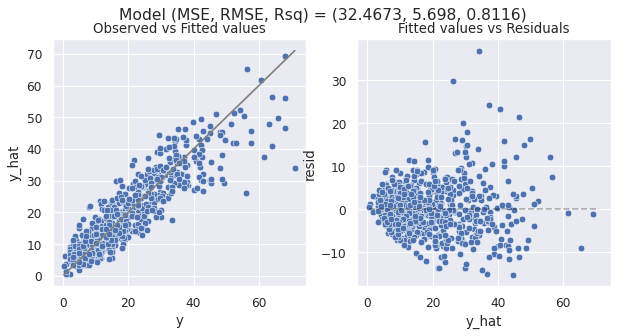

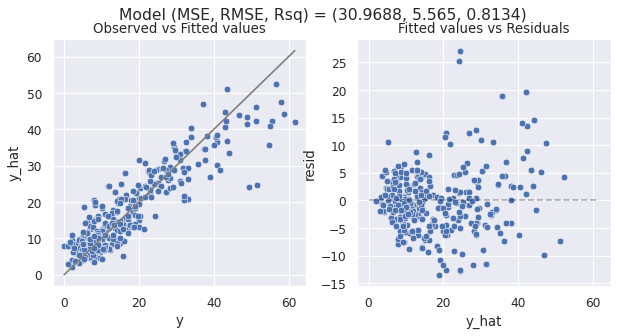

In [24]:
MSE_train, RMSE_train, Rsqr_train = model_fit(best_lasso_model, X_train, y_train, plot=True)
MSE_test, RMSE_test, Rsqr_test = model_fit(best_lasso_model, X_test, y_test, plot=True)

*Figure 7: Diagnostic Plots for Lasso Model Performance*

Figure 7 illustrates the performance of our final Lasso model, which incorporates polynomial interaction terms, on both the training and test datasets. The figure includes two diagnostic plots: one showing Observed vs. Fitted values and another depicting Fitted values vs. Residuals. The Observed vs. Fitted plot reveals that the model's predictions are closely aligned with the actual outcomes, as most points lie near the identity line, indicating good predictive accuracy. Meanwhile, the Fitted vs. Residuals plot shows that the residuals are randomly dispersed around zero with no apparent pattern, suggesting that the model assumptions such as linearity and homoscedasticity are reasonably met.

In [25]:
print(f"Test performance Lasso Model - MSE:{MSE_test}, RMSE:{RMSE_test}, Rsqr:{Rsqr_test}")
print(f"Test performance Baseline Model - MSE:{MSE_test_base}, RMSE:{RMSE_test_base}, Rsqr:{Rsqr_test_base}")

Test performance Lasso Model - MSE:30.968787348741337, RMSE:5.5649606780948, Rsqr:0.8134263211919571
Test performance Baseline Model - MSE:34.08494157604819, RMSE:5.838231031403963, Rsqr:0.7946528267255843


Our final Lasso model achieved a test Mean Squared Error (MSE) of approximately 30.97, with a Root Mean Squared Error (RMSE) of about 5.56 and an R² of 0.813. In contrast, the baseline linear regression model yielded a test MSE of approximately 34.08, an RMSE of about 5.84, and an R² of 0.795. These results indicate that the Lasso model not only reduces the prediction error but also explains a greater proportion of the variance in the target variable.

To examine which features mattered the most, we extracted both standardized and unstandardized coefficients:

In [26]:
# Extracting trained Lasso model
model = best_lasso_model.named_steps["model"]  # Lasso model

# Geting feature names after Polynomial Transformation
fe_names = best_lasso_model.named_steps["poly"].get_feature_names_out(
    best_lasso_model.named_steps["pre_processing"].get_feature_names_out()
)

# Store coefficients
coefs = pd.DataFrame(
    np.copy(model.coef_),  
    columns=["Coefficients"],
    index=fe_names,
)

# Display nonzero coefficients (important features)
coefs= coefs[coefs["Coefficients"] != 0]

In [27]:
# Extracting the scaler step
scaler = best_lasso_model.named_steps["scaler"]

# Geting feature names after Polynomial Transformation
fe_names = best_lasso_model.named_steps["poly"].get_feature_names_out(
    best_lasso_model.named_steps["pre_processing"].get_feature_names_out()
)

# Unstandardizing
ucoef = model.coef_ / scaler.scale_  

# Storing unstandardized coefficients
ucoef_ = pd.DataFrame(
    ucoef,
    columns=["Unstandardized Coefficients"],
    index=fe_names  # Feature names after polynomial expansion
)

# Displaying nonzero coefficients
ucoef_ = ucoef_[ucoef_["Unstandardized Coefficients"] != 0]

Below, Figure 8 displays two plots showing standardized vs. unstandardized coefficients:

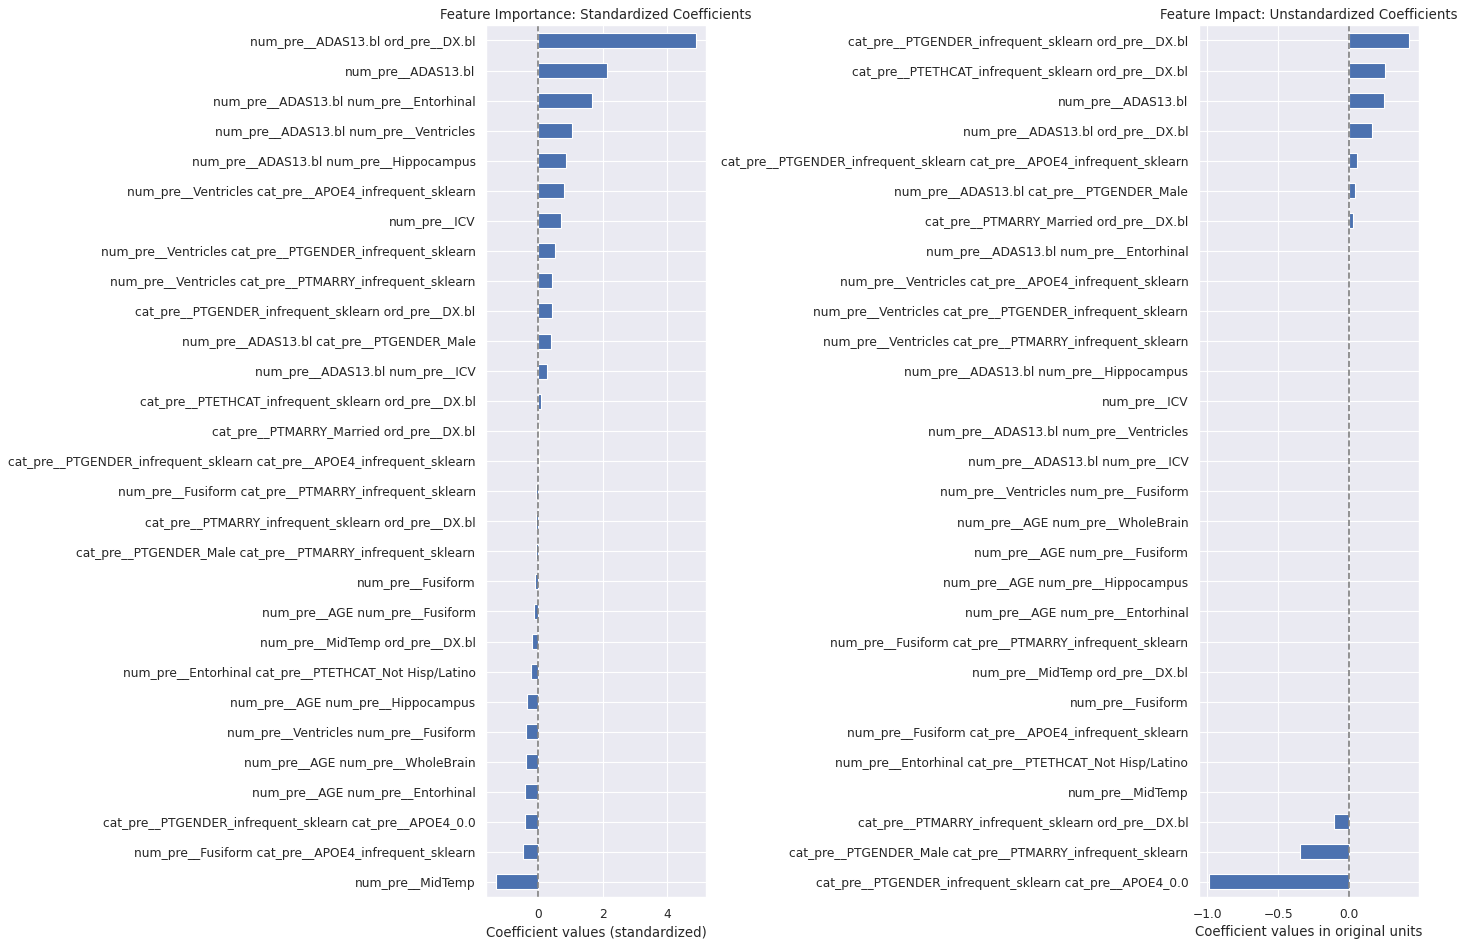

In [41]:
fig, axes = plt.subplots(figsize=(18, 12), nrows=1, ncols=2)

# Sorted standardized coefficients
sorted_coefs = coefs.sort_values(by="Coefficients", ascending=True)

# Sorted unstandardized coefficients
sorted_ucoefs = ucoef_.sort_values(by="Unstandardized Coefficients", ascending=True)

# Standardized Coefficients Plot
sorted_coefs.plot.barh(ax=axes[0], legend=False)
axes[0].set_title("Feature Importance: Standardized Coefficients")
axes[0].axvline(x=0, color=".5", linestyle="--")
axes[0].set_xlabel("Coefficient values (standardized)")

# Unstandardized Coefficients Plot
sorted_ucoefs.plot.barh(ax=axes[1], legend=False)
axes[1].set_title("Feature Impact: Unstandardized Coefficients")
axes[1].axvline(x=0, color=".5", linestyle="--")
axes[1].set_xlabel("Coefficient values in original units")

plt.tight_layout()
plt.show()

*Figure 8: Comparison of Standardized vs. Unstandardized Coefficients of the Final Model*

The two plots provide complementary insights into our model's predictions. The left plot displays the standardized coefficients from our final Lasso model, which indicate the relative importance of each feature in predicting the ADAS score after two years. In other words, it shows which predictors have the strongest influence in terms of standard deviation changes. The right plot, on the other hand, presents the unstandardized coefficients, revealing the real-world impact of each feature specifically, the change in the predicted ADAS score for each one unit increase in the feature's original measurement. Together, these visualizations help us understand not only which features are most critical, but also how changes in their actual values affect future cognitive performance.

Finally, we show in a single table (Table 3) the Unstandardized Coefficients:

In [29]:
print("Table 3: Unstandardized Coefficients of the Final Model")
print(sorted_ucoefs)

Table 3: Unstandardized Coefficients of the Final Model
                                                    Unstandardized Coefficients
cat_pre__PTGENDER_infrequent_sklearn cat_pre__A...                -9.885015e-01
cat_pre__PTGENDER_Male cat_pre__PTMARRY_infrequ...                -3.448199e-01
cat_pre__PTMARRY_infrequent_sklearn ord_pre__DX.bl                -1.111499e-01
num_pre__MidTemp                                                  -4.613807e-04
num_pre__Entorhinal cat_pre__PTETHCAT_Not Hisp/...                -2.470966e-04
num_pre__Fusiform cat_pre__APOE4_infrequent_skl...                -5.459804e-05
num_pre__Fusiform                                                 -4.689815e-05
num_pre__MidTemp ord_pre__DX.bl                                   -9.406236e-06
num_pre__Fusiform cat_pre__PTMARRY_infrequent_s...                -8.513796e-06
num_pre__AGE num_pre__Entorhinal                                  -7.227479e-06
num_pre__AGE num_pre__Hippocampus                               

This table shows the unstandardized coefficient (effect of a one-unit increase in the original scale). It helps identify how changes in those features translate into real-world impact on the ADAS score.

# Discussion & Conclusions

Our model, the polynomial-Lasso model, has shown strong predictive performance for cognitive decline at 24 months, yielding a Mean Squared Error of approximately 30.97, a Root Mean Squared Error of about 5.56, and an R² of around 0.813. In practical terms, this means the model, on average, deviates from observed the ADAS-Cog 13 score at 24-month by roughly 5.6 points while explaining over 81% of the outcome’s variability. This result indicates that the model can be a reliable tool for identifying individuals likely to experience a faster progression of Alzheimer’s.

A very notable predictor of the results based on the Figure 8 plot for standardized coefficients are the volumetric measurements of various parts in the brain. Most importantly, the size of the mid-temporal lobe alone appears to directly reduce the predicted score, implying a larger mid-temportal lobe confers some resistance to Alzheimer's. Conversely, increased ventricular size tends to raise the predicted score, aligning with well-documented evidence that brain atrophy accelerates cognitive impairment. These findings echo reports such as Rao YL et al. (2022), which highlight how atrophic changes in regions like the hippocampus or entorhinal cortex are closely related to Alzheimer’s progression. Our model’s interactions with APOE4 (cited in works like Pires M et al., 2023) further reinforce the gene’s recognized importance in raising the risk profile, particularly when coupled with certain patterns of brain atrophy.

Since looking at Figure 8 (Left Plot) shows that the most important features influencing the 24-month ADAS score are the volumetric measurements of various brain regions, the baseline ADAS13.bl score, APOE4, and the baseline diagnosis (DX.bl), we should consider how to interpret these effects in real-world terms. To do this, we can refer to the unstandardized coefficients in Table 3. For example, take the feature num_pre__ADAS13.bl ord_pre__DX.bl, which has an unstandardized coefficient of 0.16. Suppose someone arrives with a baseline ADAS13.bl score of 15 and a diagnosis of Early Mild Cognitive Impairment (EMCI). Since CN = 0, EMCI = 1, LMCI = 2, and AD = 3, the calculation becomes 0.16 × 15 × 1, producing an increase of 2.4 points in the predicted ADAS score at 24 months compared to an individual with the same baseline score who was cognitively normal (CN). That is how you can interpret Table 3 to obtain real-world impact values from the unstandardized coefficients.

Following the above, in practical terms these insights offer several advantages for clinicians and health professionals. Individuals with high baseline ADAS13 scores, especially in severe diagnostic categories, could be flagged for more frequent assessments or early interventions. Monitoring changes in structural MRI measures, such as hippocampal volume or mid‑temporal lobe thickness, may serve as an important indicator of disease progression. Additionally, identifying individuals who carry APOE4 can guide personalized treatment decisions, particularly when genetic risk factors coincide with volumetric findings suggestive of rapid decline.

Despite its strong predictive performance, the model’s correlations should not be interpreted as direct evidence of causation. In other words, a larger mid‑temporal region may be associated with a slower decline, yet there is no guarantee that modifying this anatomical feature alone could prevent the progression of Alzheimer’s disease. The model’s demographic coverage is another concern, because the data may not represent all populations, it remains uncertain how well these findings generalize to diverse groups. Exploring broader datasets or validating the model in different clinical settings could address this limitation. Furthermore, although this model outperforms the other tested models the improvements are relatively minimal, thus any new data could potentially favor a different model.

In sum, this polynomial Lasso model highlights several factors that appear intimately linked to cognitive decline over two years, including baseline cognitive status, volumetric indicators of brain health, and genetic predisposition. By integrating these predictors, it offers a credible means to identify individuals at higher risk for future decline and to guide decisions about monitoring intervals, early clinical intervention, and targeted therapeutic strategies. While further validation and potentially larger, more diverse samples are required, these results endorse a wider clinical focus on combined cognitive testing, imaging, and genetic screening in the ongoing effort to combat Alzheimer’s disease.

# Generative AI statement

Generative AI was used for generating explanations for error messages and debugging, providing hints or suggestions to improve code, enhancing visualizations and the quality of the report.

# References

Sharp ES, Gatz M. Relationship between education and dementia: an updated systematic review. Alzheimer Dis Assoc Disord. 2011 Oct-Dec;25(4):289-304. doi: 10.1097/WAD.0b013e318211c83c. PMID: 21750453; PMCID: PMC3193875.

Rao YL, Ganaraja B, Murlimanju BV, Joy T, Krishnamurthy A, Agrawal A. Hippocampus and its involvement in Alzheimer's disease: a review. 3 Biotech. 2022 Feb;12(2):55. doi: 10.1007/s13205-022-03123-4. Epub 2022 Feb 1. PMID: 35116217; PMCID: PMC8807768.

Pires M, Rego AC. Apoe4 and Alzheimer's Disease Pathogenesis-Mitochondrial Deregulation and Targeted Therapeutic Strategies. Int J Mol Sci. 2023 Jan 1;24(1):778. doi: 10.3390/ijms24010778. PMID: 36614219; PMCID: PMC9821307.

In [42]:
!jupyter nbconvert --to pdf Final_Version.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags hide_input --TagRemovePreprocessor.remove_all_outputs_tags hide_output

[NbConvertApp] Converting notebook Final_Version.ipynb to pdf
[NbConvertApp] Support files will be in Final_Version_files/
[NbConvertApp] Making directory ./Final_Version_files
[NbConvertApp] Writing 99986 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 681177 bytes to Final_Version.pdf
